# <font color='DarkBlue'>Deep Learning & Art: Neural Style Transfer

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image 
from IPython.display import Image as inlineImage
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## <font color='Indianred'>Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely: a `content image` (C) and a `style image` (S), to create a `generated image` (G). The generated image G combines the content of the image C with the style of image S.  

## <font color='indianred'>Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called `Transfer learning`. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

* The model is stored in a python dictionary.  
* The python dictionary contains key-value pairs for each layer.  
* The 'key' is the variable name and the 'value' is a tensor for that layer. 

#### Assign input image to the model's input layer
To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:

```python
    model["input"].assign(image)
```
This assigns the image as an input to the model. 

#### Activate a layer
After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:

```python
    sess.run(model["conv4_2"])
```

## <font color='indianred'>Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function &ensp;&ensp;$J_{content}(C,G)$
- Build the style cost function   &ensp;&ensp;$J_{style}(S,G)$
- Put it together                 &ensp;&ensp;$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### <font color='indigo'>Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

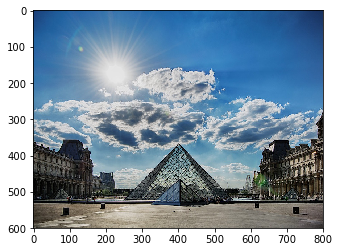

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image);

#### Shallow vs. deep layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a middle activation layer $a^{[l]}$
* We would like the `generated` image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network - neither too shallow nor too deep. 

#### Forward propagate image `C`
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture notes, this was $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image `G`
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$

$$J_{content}(C,G) =  \frac{1}{4 \cdot n_H \cdot n_W \cdot n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

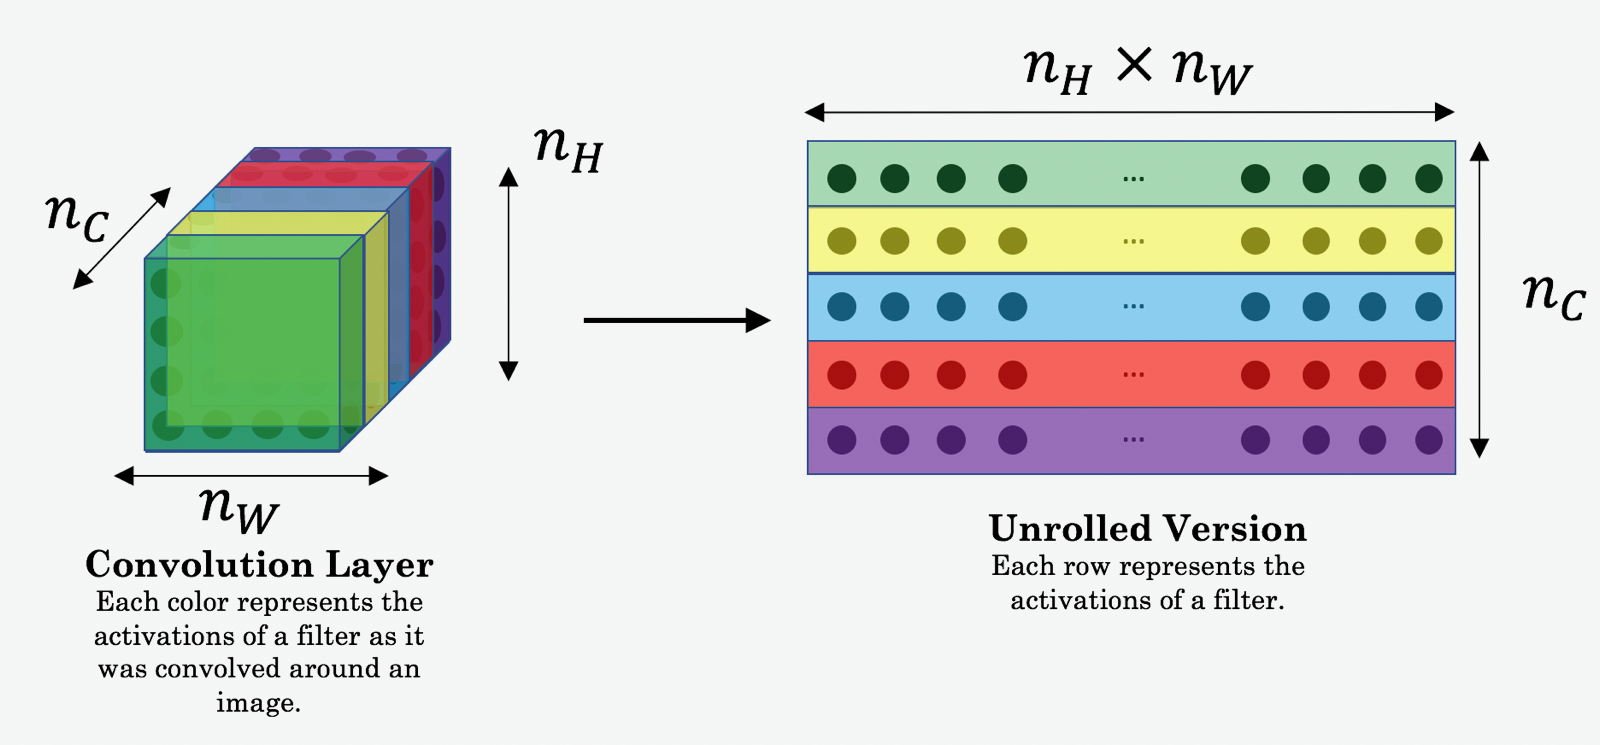

In [4]:
inlineImage('images/NST_LOSS.png', height=400, width=800)

**Exercise:** Compute the `content cost` 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
    - To retrieve dimensions from a tensor `X`, use: `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G` as explained in the picture above
    - You'll likey want to use these functions: `tf.transpose` and `tf.reshape`.
3. Compute the content cost:
    - You'll likely want to use these functions: `tf.reduce_sum`, `tf.square` and `tf.subtract`.
    
    
#### Additional Hints
* To unroll the tensor, we want the shape to change from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` takes a list of integers that represent the desired output shape.
* For the `shape` parameter, a `-1` tells the function to choose the correct dimension size so that the output tensor still contains all original values.
* `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` $\equiv$ `tf.reshape(a_C, shape=[m, -1, n_C])`.
* If you prefer to re-order the dimensions, you can use `tf.transpose(tensor, perm)`, where `perm` is a list of integers containing the original index of the dimensions. For example, `tf.transpose(a_C, perm=[0,3,1,2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.


In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, n_H * n_W, n_C]))
    
    # compute costs
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) * (1 / (4 * n_H * n_W * n_C))
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


#### Notes
- The content cost takes a hidden layer activations, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### <font color='indigo'>Computing the style cost

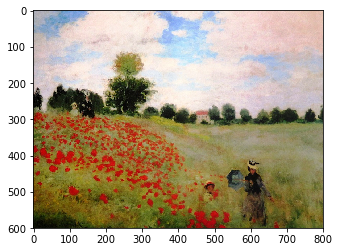

In [7]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image);

#### Gram matrix
* The Style matrix is also called a `Gram matrix`. 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:



$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

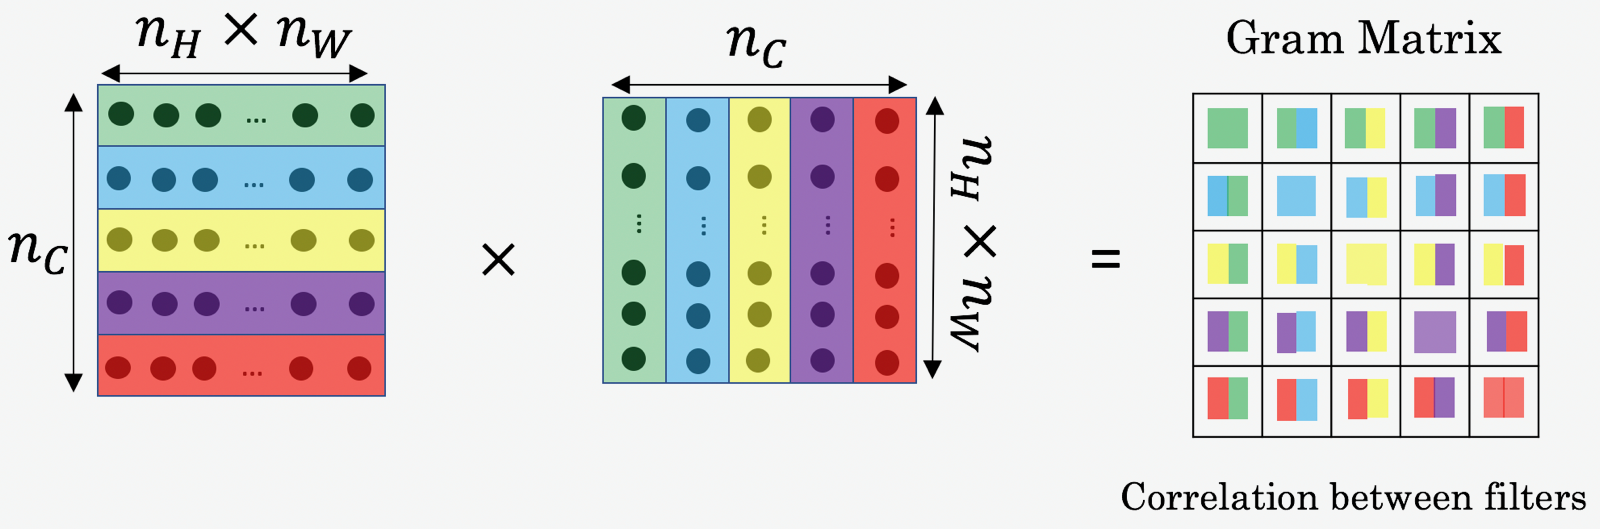

In [8]:
inlineImage("images/NST_GM.png", width=900,height=400)

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram) i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how active a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

**Exercise**:
* Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. 
* The formula is: The gram matrix of A is $G_A = AA^T$. 
* You may use these functions: `matmul` and `transpose`

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


#### Style cost

Your goal will be to minimize the distance between the Gram matrix of the style image S and the gram matrix of the generated image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix "style" image, $G_{gram}^{(G)}$ for the "generated" image.
* This cost is computed using the hidden layer activations for a particular hidden layer i.e $a^{[l]}$


**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices.
    - You may use `tf.transpose`, `tf.reshape`.
3. Compute the Style matrix of the images S and G. 
4. Compute the Style cost:
    - You may find `tf.reduce_sum`, `tf.square`,`tf.subtract` useful.
    
    
#### Additional
* Since the activation dimensions are $(m, n_H, n_W, n_C)$ whereas the desired unrolled matrix shape is $(n_C, n_H*n_W)$, the order of the filter dimension $n_C$ is changed.  So `tf.transpose` can be used to change the order of the filter dimension.
* For the product $\mathbf{G}_{gram} = \mathbf{A}_{} \mathbf{A}_{}^T$, you will also need to specify the `perm` parameter for the `tf.transpose` function.

In [11]:
def compute_layer_style_cost(a_S, a_G):
    
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    #J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GG,GS))) * 1/(4 * ((n_C)**2) * ((n_H*n_W)**2)) 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GG,GS))) * 1/(4 * ((n_H*n_W*n_C)**2))
    return J_style_layer

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


### Style Weights

* So far you have captured the style from only one layer. We'll get better results if we merge style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [13]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


**Exercise: compute style cost**

* We've implemented a `compute_style_cost()` function. It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

#### Description of `compute_style_cost()`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image S from the current layer.
* Get the style of the generated image G from the current layer.
* Compute the style cost for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [14]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model        -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style      -- tensor representing a scalar value, style cost defined above
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

### <font color='Indigo'>Defining the total optimization cost

The total cost: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style    
    return J

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## <font color='IndianRed'>Solving Optimization Problem

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

#### Interactive Sessions

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, your program has to reset the graph and use an `Interactive Session`. Unlike a regular session, the `Interactive Session` installs itself as the default session to build a graph. This allows you to run variables without constantly needing to refer to the session object (calling `sess.run()`), which simplifies the code.

In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### Content image 
Load, reshape, and normalize `content` image 

In [18]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

#### Style image
Load, reshape and normalize our `style` image

In [19]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
Now, we initialize the `generated` image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

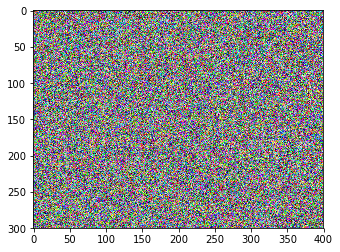

In [20]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [21]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

#### Content Cost

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [22]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [23]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

#### Total cost
* Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. 
* Use `alpha = 10` and `beta = 40`.

In [24]:
J = total_cost(J_content, J_style)

#### Optimizer

In [25]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(0.8)

# define train_step (1 line)
train_step = optimizer.minimize(J)

#### Implement the model

* Implement the model_nn() function.  
* The function **initializes** the variables of the tensorflow graph, 
* **assigns** the input image (initial generated image) as the input of the VGG19 model 
* and **runs** the `train_step` tensor (it was created in the code above this function) for a large number of steps.

#### Hints
* To initialize global variables, use this: 
```Python
    sess.run(tf.global_variables_initializer())
```
* Run `sess.run()` to evaluate a variable.
* [assign](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/assign) can be used like this:
```python
    model["input"].assign(image)
```

In [26]:
def model_nn(sess, input_image, num_iterations = 150):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
                
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Print every 20 iteration.
        if i % 50 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration    = " + str(i) + " :")
            print("total cost   = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost   = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    return generated_image

In [27]:
model_nn(sess, generated_image)

Iteration    = 0 :
total cost   = 5.44372e+09
content cost = 7512.02
style cost   = 1.36091e+08
Iteration    = 50 :
total cost   = 7.52576e+08
content cost = 14770.1
style cost   = 1.88107e+07
Iteration    = 100 :
total cost   = 3.82942e+08
content cost = 16401.3
style cost   = 9.56944e+06


array([[[[ -37.08300781,  -54.12427521,   42.65858078],
         [ -50.07785034,  -50.87702179,   -1.7528249 ],
         [ -70.50002289,  -44.23305893,   -8.26972675],
         ..., 
         [ -29.28483009,  -12.05562401,   18.86040306],
         [ -31.65061378,   -4.31926775,   24.39588165],
         [ -42.36302185,   -3.83034468,   45.14173126]],

        [[ -67.66929626,  -55.0655899 ,   -1.10034871],
         [ -50.6006279 ,  -43.03551483,  -18.87300873],
         [ -52.99211502,  -49.20398712,   -5.56731558],
         ..., 
         [ -36.2637825 ,  -21.33712006,   36.16987991],
         [ -31.96681404,  -29.84634399,    9.17798233],
         [ -56.50932693,  -19.9662056 ,   -1.926916  ]],

        [[ -63.66851425,  -56.79426956,   -3.4576664 ],
         [ -52.45053482,  -52.46582413,  -18.15394974],
         [ -58.74251938,  -42.61671829,   -5.51874161],
         ..., 
         [ -18.6020813 ,  -43.89184952,   22.00909805],
         [ -19.37288475,  -28.97723389,   17.87330818],

## <font color='IndianRed'>References

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
